# Classificação dos fungos Pré-processamento (Antes de qualquer tipo de processamento de imagem)

In [16]:

import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time
from PIL import Image

In [17]:
Dataset_path = "../defungi_dataset"
Image_size = (64, 128)
HOG_orientation = 9
HOG_pixels_per_cell = (8, 8)
HoG_cells_per_block = (2, 2)


In [18]:
# extrair dados

data = []
labels = []

classes_names = [d for d in os.listdir(Dataset_path) if os.path.isdir(os.path.join(Dataset_path, d))]
label_mapping = {name: i for i, name in enumerate(classes_names)}

for nome_classe,label_id in label_mapping.items():
    class_path = os.path.join(Dataset_path, nome_classe)
    for nome_imagem in os.listdir(class_path):
        image_path = os.path.join(class_path,nome_imagem)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Erro ao carregar a imagem: {image_path}")
            continue

        resized_image = cv2.resize(image, Image_size)
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        data.append(gray_image)
        labels.append(label_id)



In [19]:
# transformar as imagens em HOG features
hog_features = []
for image in data:
    features = hog(image, 
                   orientations=HOG_orientation, 
                   pixels_per_cell=HOG_pixels_per_cell, 
                   cells_per_block=HoG_cells_per_block, 
                   block_norm='L2-Hys', 
                   visualize=False)
    hog_features.append(features)


In [20]:
X = np.array(hog_features)
y = np.array(labels)

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Total de imagens: {len(data)}")
print(f"Total de classes: {len(classes_names)}")
print(f"Total de imagens de treino: {len(X_train)}")
print(f"Total de imagens de teste: {len(X_test)}")


Total de imagens: 9114
Total de classes: 5
Total de imagens de treino: 7291
Total de imagens de teste: 1823


# SVM

In [21]:
model = SVC(kernel='linear', probability=True,C=1.0, random_state=42)
model.fit(X_train, y_train)
print("Modelo treinado com sucesso!")
y_pred = model.predict(X_test)


Modelo treinado com sucesso!


In [22]:
accuracy = accuracy_score(y_test, y_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")
print("\nRelatório de Classificação:")
    
# Inverte o mapa de rótulos para mostrar os nomes das classes no relatório
target_names = [name for name, i in sorted(label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_pred, target_names=target_names))


--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 45.53%

Relatório de Classificação:
              precision    recall  f1-score   support

        BASH       0.34      0.35      0.35       478
         BBH       0.21      0.21      0.21       141
         GMA       0.18      0.18      0.18       153
         SHC       0.36      0.33      0.34       164
         TSH       0.62      0.62      0.62       887

    accuracy                           0.46      1823
   macro avg       0.34      0.34      0.34      1823
weighted avg       0.45      0.46      0.45      1823



# Matriz de confusão

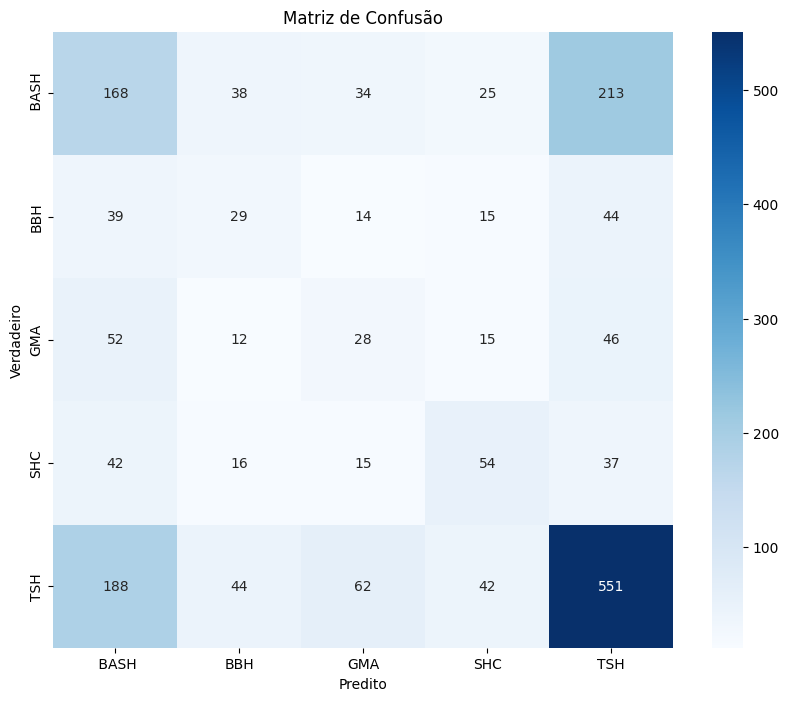

In [23]:
# matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# KNN

In [24]:
model_knn = KNeighborsClassifier()

# Busca por hiperparâmetros (número de vizinhos) usando GridSearchCV
param_grid = {'n_neighbors': [5]}  # Testando diferentes valores de k
grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtendo o melhor modelo
model_knn = grid_search.best_estimator_
print(f"Modelo KNN treinado com sucesso! Melhor número de vizinhos: {grid_search.best_params_['n_neighbors']}")

# Avaliação com validação cruzada
cv_scores = cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nAcurácia média na validação cruzada (5-fold): {np.mean(cv_scores):.2%} ± {np.std(cv_scores):.2%}")

# Previsões no conjunto de teste
y_knn_pred = model_knn.predict(X_test)

Modelo KNN treinado com sucesso! Melhor número de vizinhos: 5

Acurácia média na validação cruzada (5-fold): 37.36% ± 1.54%


In [25]:
accuracy = accuracy_score(y_test, y_knn_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")
print("\nRelatório de Classificação:")
    
# Inverte o mapa de rótulos para mostrar os nomes das classes no relatório
target_names = [name for name, i in sorted(label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_knn_pred, target_names=target_names))


--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 36.42%

Relatório de Classificação:
              precision    recall  f1-score   support

        BASH       0.32      0.15      0.21       478
         BBH       0.13      0.19      0.16       141
         GMA       0.10      0.08      0.09       153
         SHC       0.14      0.48      0.22       164
         TSH       0.66      0.53      0.59       887

    accuracy                           0.36      1823
   macro avg       0.27      0.29      0.25      1823
weighted avg       0.44      0.36      0.38      1823



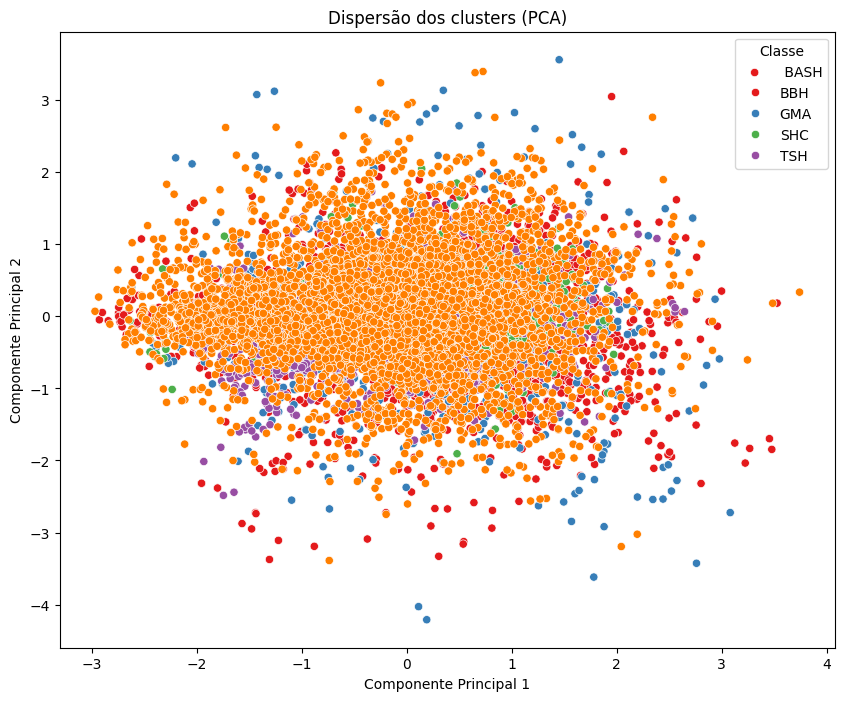

In [26]:
from sklearn.decomposition import PCA

# Visualização da dispersão dos clusters usando PCA para reduzir a dimensionalidade

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1', legend='full')
plt.title('Dispersão dos clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Classe', labels=target_names)
plt.show()

# CNN

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
# Configurar ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [30]:
# Carregar dados
train_generator = train_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 8206 images belonging to 5 classes.
Found 908 images belonging to 5 classes.


In [31]:
# Criar e treinar o modelo
input_shape = (128, 128, 1)
num_classes = len(train_generator.class_indices)
model = create_cnn_model(input_shape, num_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

print("Modelo treinado com sucesso!")

Epoch 1/50


/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4248 - loss: 2.0549

256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.4249 - loss: 2.0531 - val_accuracy: 0.4833 - val_loss: 2.0577
Epoch 2/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5000 - loss: 1.4335

/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 1.4335 - val_accuracy: 0.4833 - val_loss: 1.9360
Epoch 3/50
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5056 - loss: 1.2229

256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.5056 - loss: 1.2228 - val_accuracy: 0.5000 - val_loss: 1.4502
Epoch 4/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3438 - loss: 1.5767

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3438 - loss: 1.5767 - val_accuracy: 0.5022 - val_loss: 1.4254
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5231 - loss: 1.1508

256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.5231 - loss: 1.1508 - val_accuracy: 0.5190 - val_loss: 1.1348
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5938 - loss: 0.9760 - val_accuracy: 0.5089 - val_loss: 1.1330
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5269 - loss: 1.1395

256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.5270 - loss: 1.1395 - val_accuracy: 0.5290 - val_loss: 1.1751
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 0.8123 - val_accuracy: 0.5290 - val_loss: 1.1937
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.5460 - loss: 1.1091 - val_accuracy: 0.1004 - val_loss: 1.7238
Epoch 10/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 1.0371 - val_accuracy: 0.1629 - val_loss: 1.6340
Epoch 11/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5469 - loss: 1.0901 - val_accuracy: 0.3817 - val_loss: 1.4594
Epoch 12/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4062 - loss: 1.4311 - val_accuracy: 0.3650 - val_loss: 1.4832
Epoch 13/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.5516 - loss: 1.0862 - val_accuracy: 0.0904 - val_loss: 2.9820
Epoch 14/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 1.1543 - val_accuracy: 

In [32]:
# Avaliação no conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = test_generator.classes

Found 9114 images belonging to 5 classes.
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step


In [33]:
# Resultados
accuracy = accuracy_score(y_test, y_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")

# Relatório de classificação
target_names = list(train_generator.class_indices.keys())
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=target_names))



--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 53.15%

Relatório de Classificação:
              precision    recall  f1-score   support

        BASH       0.34      0.44      0.39      2334
         BBH       0.31      0.29      0.30       739
         GMA       0.34      0.02      0.03       819
         SHC       0.70      0.24      0.36       818
         TSH       0.66      0.77      0.71      4404

    accuracy                           0.53      9114
   macro avg       0.47      0.35      0.36      9114
weighted avg       0.53      0.53      0.50      9114



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Classe prevista:  BASH
Classe real:  BASH
Resultado: ACERTOU


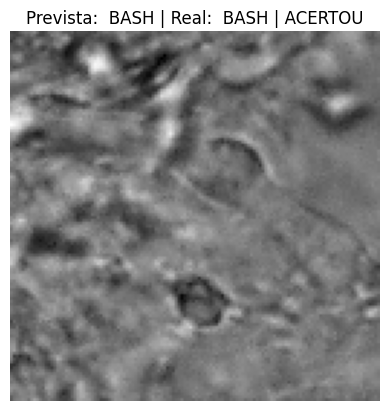

In [47]:
# Seleciona uma imagem do conjunto de teste do gerador (por exemplo, a primeira)
test_img_batch, test_label_batch = next(test_generator)
test_img = test_img_batch[0]
real_class = int(test_label_batch[0])

# Faz a predição
pred_prob = model.predict(np.expand_dims(test_img, axis=0))
pred_class = np.argmax(pred_prob, axis=1)[0]

# Verifica se acertou
acertou = pred_class == real_class
resultado = "ACERTOU" if acertou else "ERROU"

print(f"Classe prevista: {target_names[pred_class]}")
print(f"Classe real: {target_names[real_class]}")
print(f"Resultado: {resultado}")

plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(f"Prevista: {target_names[pred_class]} | Real: {target_names[real_class]} | {resultado}")
plt.axis('off')
plt.show()

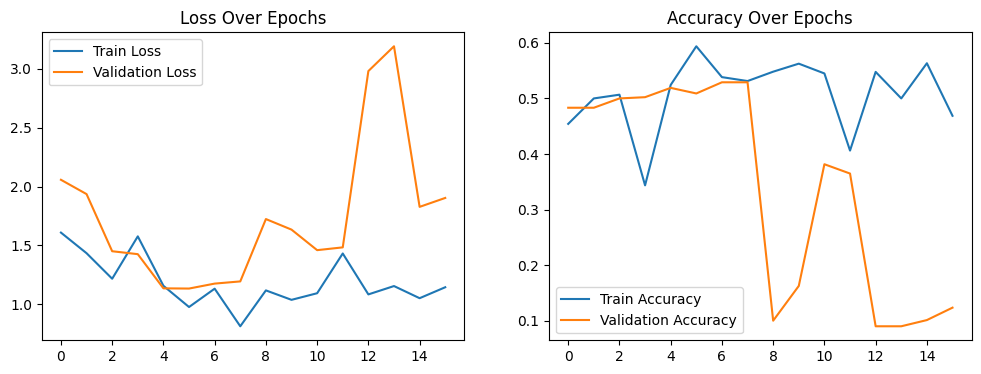

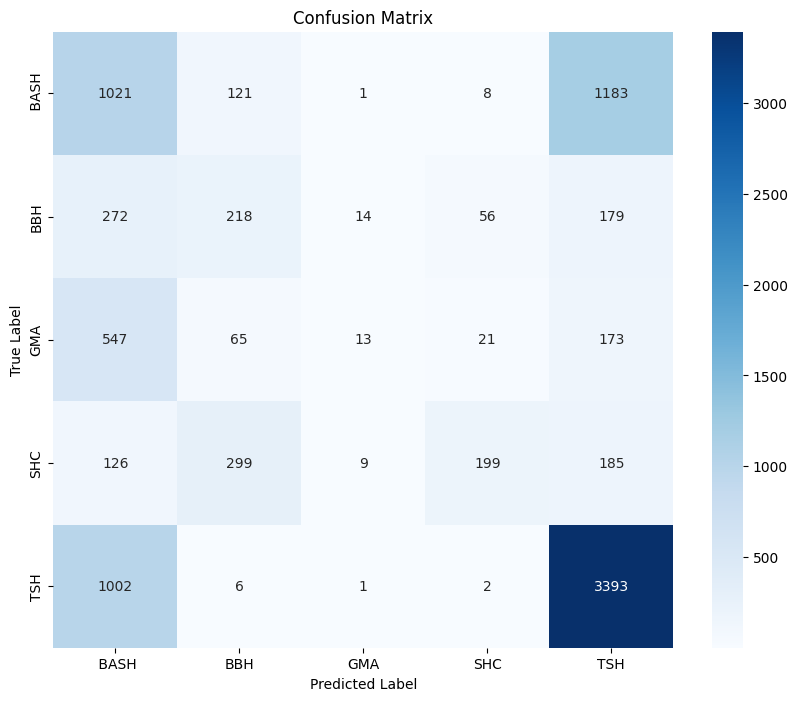

In [35]:
# Curvas de aprendizado
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Matriz de confusão com nomes corretos
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Como ficaram as 10 primeiras e 10 últimas imagens de cada pasta

In [ ]:
# Primeira pasta
first_class = classes_names[0]
first_class_path = os.path.join(Dataset_path, first_class)
first_class_images = os.listdir(first_class_path)[:10]
print(f"\nPrimeiras 10 imagens da pasta '{first_class}':")
for img_name in first_class_images:
    img_path = os.path.join(first_class_path, img_name)
    # Exibir a imagem
    img = cv2.imread(img_path)
    #usar matplotlib para exibir a imagem
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{first_class} - {img_name}")
    plt.axis('off')
    plt.show()
        

In [ ]:
#Segunda pasta
second_class = classes_names[1]
second_class_path = os.path.join(Dataset_path, second_class)
second_class_images = os.listdir(second_class_path)[:10]
print(f"\nPrimeiras 10 imagens da pasta '{second_class}':")
for img_name in second_class_images:
    img_path = os.path.join(second_class_path, img_name)
    # Exibir a imagem
    #colocar em grayscale
    gray_image = cv2.imread(img_path)
    img = gray_image
    #usar matplotlib para exibir a imagem
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{second_class} - {img_name}")
    plt.axis('off')
    plt.show()